# Mode Collapse Comparison

## Number of Statistically-Distinct Bin (NDB)
* divide real samples into clusters (bins) and count how well generated samples spread over these bins.
* NDB measures how well teh generated samples distribute across these clusters.

## Jenson-Shannon Divergence (JSD)
* JSD quantifies the divergence between real and generated cluster distributions.

* [**Lower JSD** = **Higher NDB** = lesser mode collapse] 

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import torch

In [2]:
# Load original dataset
real_data = np.load('./hydFoil_data/resampled_hydrofoils.npy')

In [3]:
# Flatten original dataset
real_data = real_data.reshape(real_data.shape[0], -1)

In [4]:
real_data.shape

(1528, 400)

In [5]:
# PCA embedding
pca = PCA(n_components=100)

real_data_pca = pca.fit_transform(real_data)

In [6]:
# cluster into K-bins
kmeans = KMeans(n_clusters=100)

real_labels = kmeans.fit_predict(real_data_pca)

# Load Both Models

In [7]:

# Hyperparamter for training
LATENT_DIM = 3
NOISE_DIM = 10

#checkpoint_bgan = torch.load("./trained_gan/3_10/checkpoints/model_epoch_2000.pth")
checkpoint_bhgan = torch.load("./trained_gan/3_10/checkpoints/model_epoch_10000.pth")

In [8]:
# load teh model 
from hydFoilGAN.gan import *

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator model to load from checkpoints
gen_bhgan = Generator(latent_dim=LATENT_DIM,
                     noise_dim=NOISE_DIM).to(device)

In [10]:
# load state_dict from checkpoint
gen_bhgan.load_state_dict(checkpoint_bhgan['model_G_state_dict'])

<All keys matched successfully>

In [42]:
# Generate samples for NDB and JSD

n_samples = 5000
batch_size = 32
bhgan_pointclouds =  gen_bhgan.generate_hydrofoil_pointclouds(n_samples,
                                                            batch_size)

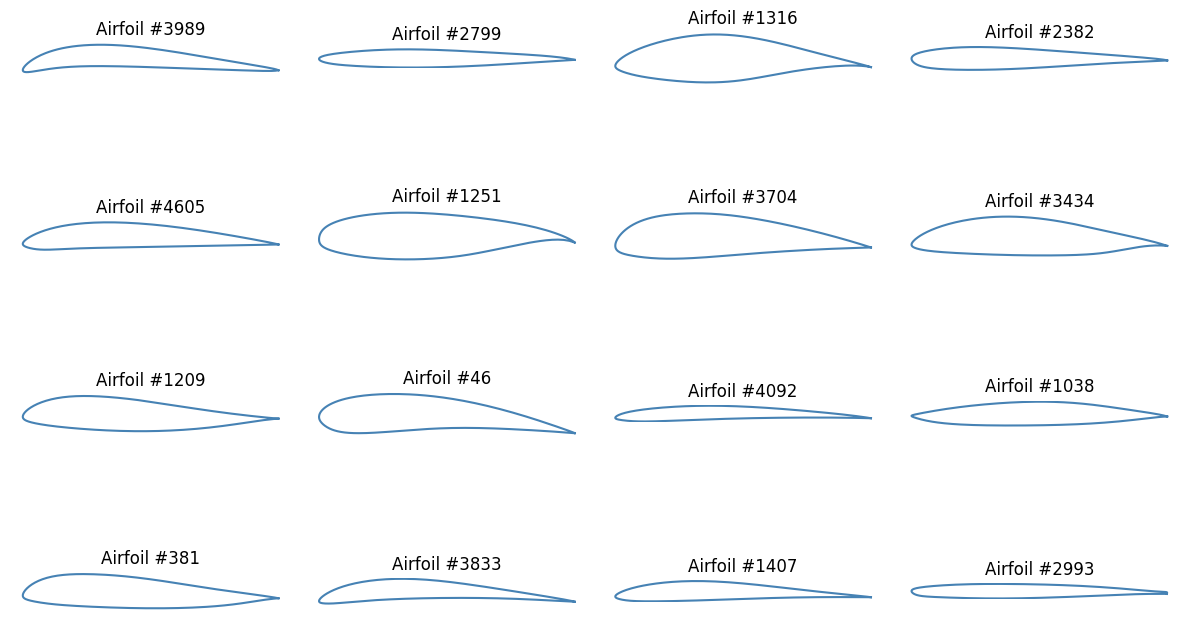

In [47]:
N = bhgan_pointclouds.shape[0]
idx = np.random.choice(N, 16, replace=False)
selected_airfoils = bhgan_pointclouds[idx]  # shape (16, 200, 2)

fig, axes = plt.subplots(4, 4, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    airfoil = selected_airfoils[i]
    ax.plot(airfoil[:, 0], airfoil[:, 1], color='steelblue')
    ax.set_title(f'Airfoil #{idx[i]}')
    #ax.axis('equal')
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Flatten generated samples
bhgan_pointclouds = bhgan_pointclouds.reshape(bhgan_pointclouds.shape[0], -1)

In [41]:
bhgan_pointclouds.shape

(5000, 400)

In [14]:
# project generated data inot PCA space
bhgan_pointclouds_pca = pca.transform(bhgan_pointclouds)

In [15]:
# Assign labels to generated samples
bhgan_labels = kmeans.predict(bhgan_pointclouds_pca)

In [16]:
NDB_bins = 100
N_r = len(real_labels)
N_g = len(bhgan_labels)

In [17]:
# Counts samples per bin
n_r = np.bincount(real_labels, minlength=NDB_bins)
n_g = np.bincount(bhgan_labels, minlength=NDB_bins)

In [18]:
print(n_r)
print(n_g)

[36 26 15 40  5 22 17  2 10 24  6 11  3 15 15 50 44 28 28  1  5 15 19 23
 19  4 14 21 23  4 32  3 30 27 17  2 27  3  5 27 35 40 13 19  1  1  8 13
 22  7 20  7  7 30 16  6  1 11  1 11 34 17 28  1  1  3  1  6  2 24 22  4
 22 18  9  9  9  3 19  1  9 51 15  7  1 10  7 12 10  8  9 16 13  6 19 44
 22 37  2 10]
[   0    0    0    0    0    0    0   10    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 4990    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [19]:
from scipy.stats import norm
# Statistical test per bin
ndb = 0
for i in range(NDB_bins):
    p_r = n_r[i] / N_r
    p_g = n_g[i] / N_g
    p = (n_r[i] + n_g[i]) / (N_r + N_g)
    se = np.sqrt(p * (1-p) * (1/N_r + 1/N_g))
    z = (p_r - p_g) / se if se > 0 else 0
    pval = 2 * (1 - norm.cdf(abs(z)))
    if pval < 0.05:
        ndb += 1
print(f"Number of statistically distinct bins: {ndb}")
print(f"NDB score: {ndb} / {NDB_bins}")

Number of statistically distinct bins: 90
NDB score: 90 / 100


# Jenson-Shannon Divergence


In [20]:
# * JSD quantifies the divergence between real and generated cluster distributions.
#
# * [**Lower JSD** = **Higher NDB** = lesser mode collapse]
from scipy.spatial.distance import jensenshannon

jsd = jensenshannon(n_r/n_g.sum(), n_g/n_g.sum())**2

In [21]:
jsd

np.float64(0.6893109572819737)

In [22]:
# Normalized distribution
real_probs = n_r / n_r.sum()
gen_probs = n_g / n_g.sum()


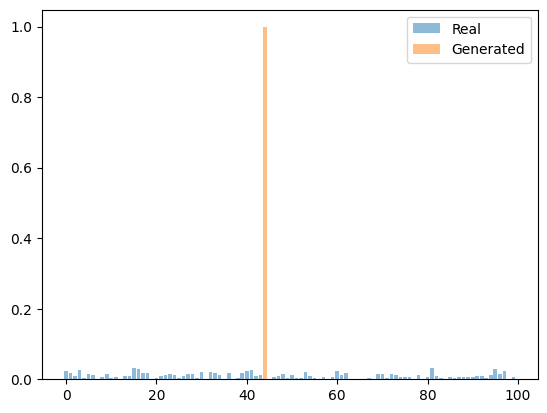

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(100), real_probs, alpha=0.5, label='Real')
plt.bar(range(100), gen_probs, alpha=0.5, label='Generated')
plt.legend()
plt.show()


# t-SNE Plots

In [24]:
X = np.vstack([real_data, bhgan_pointclouds])
y = np.array(['Real']*len(real_data) + ['Generated']*len(bhgan_pointclouds))

In [25]:
# Run t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000)
X_tsne = tsne.fit_transform(X)

/mnt/scratch/rraj/venvs/py311/lib64/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


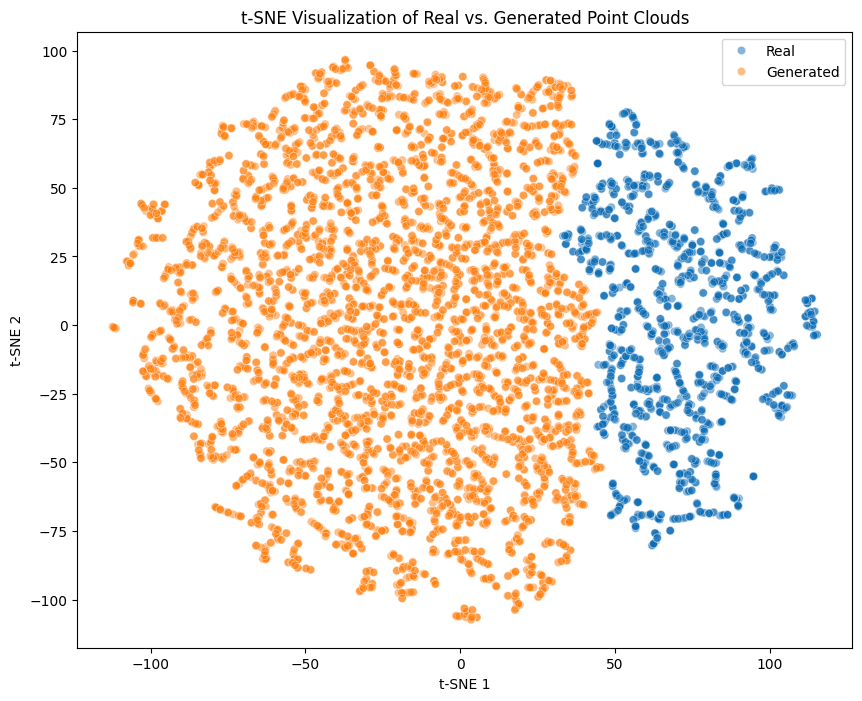

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=["#086ab4","#ff7f0e"],
    alpha=0.5,
    legend="full"
)
#plt.legend(['Real', 'Generated'])
plt.title("t-SNE Visualization of Real vs. Generated Point Clouds")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


# t-SNE plot of only generated samples

In [27]:
#Run t-SNE

X_tsne = tsne.fit_transform(bhgan_pointclouds)

/mnt/scratch/rraj/venvs/py311/lib64/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


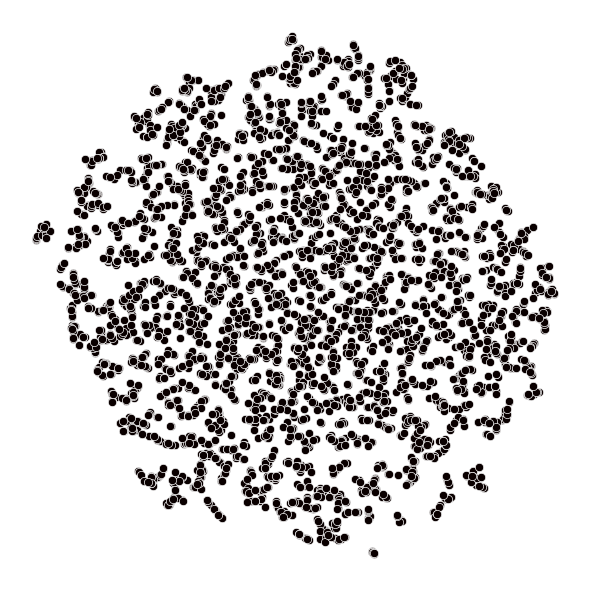

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    #hue=y,
    #palette="#070000",
    #alpha=0,
    legend="full",
    color="#0a0000"
)
# plt.legend(['Real', 'Generated'])
# plt.title("t-SNE Visualization of Generated Point Clouds")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.axis('off')
#plt.show()
plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.savefig("tsne.svg", dpi=300) # Save the plot with high resolution
#plt.close(fig) # Close the figure to free up memory

# MMD kernel test

In [29]:
from sklearn.metrics.pairwise import pairwise_kernels

In [30]:
# define MMD kernels
def compute_mmd(X,
                Y,
                kernel='rbf',
                gamma=1.0):
    XX = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
    YY = pairwise_kernels(Y, Y, metric=kernel, gamma=gamma)
    XY = pairwise_kernels(X, Y, metric=kernel, gamma=gamma)
    n = X.shape[0]
    m = Y.shape[0]
    mmd = XX.sum() / (n * n) + YY.sum() / (m * m) - 2 * XY.sum() / (n * m)

    return mmd

In [31]:
# Set kernel length to 1
# so gamma = 1/(2*sigma**2) = 0.5
gamma = 0.5

mmd_score = compute_mmd(real_data,
                        bhgan_pointclouds,
                        kernel='rbf',
                        gamma=gamma)

In [32]:
mmd_score

np.float64(1.7463926334867828)

In [39]:
# Real vs real subsets for MMD score
def real_vs_real_mmd(real_data, gamma=0.5):
    N = real_data.shape[0]
    # randomly split real data into two subsets
    split_idx = np.random.randint(int(0.3*N), int(0.7*N))
    indices = np.random.permutation(N)
    real_1 = real_data[indices[:split_idx]]
    real_2 = real_data[indices[split_idx:]]
    mmd_score = compute_mmd(real_1,
                            real_2,
                            kernel='rbf',
                            gamma=gamma)
    print(f"Real vs real MMD score: {mmd_score}")
    return mmd_score

In [40]:
mmd_score_real = real_vs_real_mmd(real_data)

Real vs real MMD score: 0.00022109662622771253
